# Comparison between KM, MK and MM models

In [1]:
import numpy as np
from prettytable import PrettyTable
import os
import matplotlib.pyplot as plt
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from scipy import signal
from tqdm import tqdm
from matplotlib import cm, ticker, colors
from mpmath import mp,fp
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
def f(v,kappa_s,kappa_f):
    if kappa_s==0:
        rs = n_s/np.sqrt(np.pi*v_s**2)*np.exp(-(v-u_s)**2/v_s**2)
    else:
        As = n_s/np.sqrt(np.pi*kappa_s)/v_s * sp.gamma(kappa_s)/sp.gamma(kappa_s-1/2)
        rs = As * ( 1 + (v-u_s)**2/kappa_s/v_s**2 )**(-kappa_s)
    if kappa_f==0:
        rf = n_f/np.sqrt(np.pi*v_f**2)*np.exp(-(v-u_f)**2/v_f**2)
    else:
        Af = n_f/np.sqrt(np.pi*kappa_f)/v_f * sp.gamma(kappa_f)/sp.gamma(kappa_f-1/2)
        rf = Af * ( 1 + (v-u_f)**2/kappa_f/v_f**2 )**(-kappa_f)
    return rs+rf

def PDR(w,k,kappa_s,kappa_f):
    wr,wi=w
    wc=complex(wr,wi)
    zeta_s = (wc / k - u_s) /v_s
    zeta_f = (wc / k - u_f) /v_f
    rs = rf = 0.0
    
    if kappa_s==0.0:
        rs = 2.0*(wp_s/k/v_s)**2 * (1.0 + zeta_s*plasmapy.dispersion.dispersionfunction.plasma_dispersion_func(zeta_s))
    else:
        rs = 2.0*(wp_s/k/v_s)**2 * (1.0 - 0.5/kappa_s + zeta_s*dispersion_function(zeta_s,kappa_s))
        
    if kappa_f==0.0:
        rf = 2.0*(wp_f/k/v_f)**2 * (1.0 + zeta_f*plasmapy.dispersion.dispersionfunction.plasma_dispersion_func(zeta_f))
    else:
        rf = 2.0*(wp_f/k/v_f)**2 * (1.0 - 0.5/kappa_f + zeta_f*dispersion_function(zeta_f,kappa_f))
        
    r = 1.0 + rs + rf
    return [r.real,r.imag]

def dispersion_function(zeta,kappa):
    fac = 1j * (kappa+0.5) * (kappa-0.5) / kappa**1.5 / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(fp.hyp2f1(1,2*kappa+2,kappa+2,z))
    return fac*hyp
    
def SetParas(kappa_s,kappa_f):
    if kappa_s==0.0:
        T_s = 0.5*v_s**2
    else:
        T_s = 0.5*kappa_s/(kappa_s-1.5)*v_s**2
    if kappa_f==0.0:
        T_f = 0.5*v_f**2
    else:
        T_f = 0.5*kappa_f/(kappa_f-1.5)*v_f**2
    l_s = np.sqrt( T_s / n_s / q**2 ) # $\lambda_D^2$
    l_f = np.sqrt( T_f / n_f / q**2 ) # $\lambda_D^2$
    return l_s,l_f,T_s,T_f

def PrintParas():
    paras_table = PrettyTable(['model','T','kappa','theta','lambda_D','u'])
    paras_table.add_row(['KM',  round(T_s1,4),round(kappa_s1,4),round(v_s,4),round(l_s1,4),round(u_s,4)])
    paras_table.add_row(['KM',  round(T_f1,4),'inf',            round(v_f,4),round(l_f1,4),round(u_f,4)])
    paras_table.add_row(['MK',  round(T_s2,4),'inf',            round(v_s,4),round(l_s2,4),round(u_s,4)])
    paras_table.add_row(['MK',  round(T_f2,4),round(kappa_f2,4),round(v_f,4),round(l_f2,4),round(u_f,4)])
    paras_table.add_row(['MM',  round(T_s3,4),'inf',            round(v_s,4),round(l_s3,4),round(u_s,4)])
    paras_table.add_row(['MM',  round(T_f3,4),'inf',            round(v_f,4),round(l_f3,4),round(u_f,4)])
    print(paras_table)

In [4]:
n = 1
q = 1

n_s = 0.5
n_f = 1 - n_s
v_s = 0.1
v_f = 1.
wp_s = np.sqrt( n_s * q**2 )
wp_f = np.sqrt( n_f * q**2 )
lds = v_s/wp_s

a = 10
u_f = a*v_s
u_s = 0.0

# KM model
kappa_s1 = 2
kappa_f1 = 0
# MK model
kappa_s2 = 0
kappa_f2 = 2
# MM model
kappa_s3 = 0
kappa_f3 = 0

l_s1,l_f1,T_s1,T_f1 = SetParas(kappa_s1,kappa_f1)
l_s2,l_f2,T_s2,T_f2 = SetParas(kappa_s2,kappa_f2)
l_s3,l_f3,T_s3,T_f3 = SetParas(kappa_s3,kappa_f3)
print('a=',a,'; ns=',n_s,'; nf=',n_f,'; theta_s=',v_s,'; theta_f=',v_f)
PrintParas()
print('lds=',lds)

a= 10 ; ns= 0.5 ; nf= 0.5 ; theta_s= 0.1 ; theta_f= 1.0
+-------+-------+-------+-------+----------+-----+
| model |   T   | kappa | theta | lambda_D |  u  |
+-------+-------+-------+-------+----------+-----+
|   KM  |  0.02 |   2   |  0.1  |   0.2    | 0.0 |
|   KM  |  0.5  |  inf  |  1.0  |   1.0    | 1.0 |
|   MK  | 0.005 |  inf  |  0.1  |   0.1    | 0.0 |
|   MK  |  2.0  |   2   |  1.0  |   2.0    | 1.0 |
|   MM  | 0.005 |  inf  |  0.1  |   0.1    | 0.0 |
|   MM  |  0.5  |  inf  |  1.0  |   1.0    | 1.0 |
+-------+-------+-------+-------+----------+-----+
lds= 0.1414213562373095


## MM vs KM vs MK

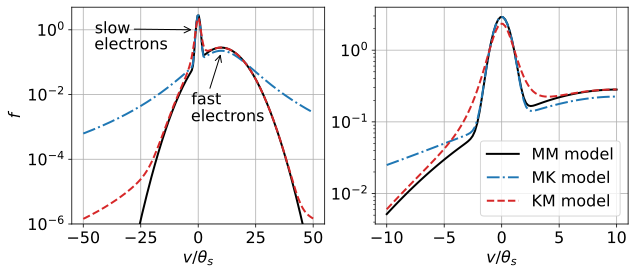

In [5]:
v_list = np.linspace(-5,5,num=200)/v_s
v_list_s = np.linspace(-1,1,num=100)/v_s
fig = plt.figure(figsize=(10,4))

ax1 = plt.subplot(121)
ax1.plot(v_list,f(v_list*v_s,kappa_s3,kappa_f3),'-',color='black',label='MM model')
ax1.plot(v_list,f(v_list*v_s,kappa_s2,kappa_f2),'-.',color='tab:blue',label='MK model')
ax1.plot(v_list,f(v_list*v_s,kappa_s1,kappa_f1),'--',color='tab:red',label='KM model')

ax1.annotate("slow",xy=(-2,1),xytext=(-45,0.78),arrowprops=dict(arrowstyle="->",color='black'))
ax1.text(x=-45.18,y=0.25,s="electrons")
ax1.annotate("fast",xy=(10,0.2),xytext=(-3,5e-3),arrowprops=dict(arrowstyle="->",color='black'))
ax1.text(x=-3.16,y=0.0015,s="electrons")

ax1.set_ylim(1e-6,5)
ax1.set_yscale('log')
ax1.set_ylabel(r'$f$')
ax1.set_xlabel(r'$v/\theta_s$')
ax1.grid()

ax2 = plt.subplot(122)
ax2.plot(v_list_s,f(v_list_s*v_s,kappa_s3,kappa_f3),'-',color='black',label='MM model')
ax2.plot(v_list_s,f(v_list_s*v_s,kappa_s2,kappa_f2),'-.',color='tab:blue',label='MK model')
ax2.plot(v_list_s,f(v_list_s*v_s,kappa_s1,kappa_f1),'--',color='tab:red',label='KM model')
# ax2.axvline(4)
# ax2.axvline(6)
ax2.set_yscale('log')
ax2.set_xlabel(r'$v/\theta_s$')
ax2.legend(loc=4)
ax2.grid()
# plt.savefig('./fig1_pdf.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [6]:
k_list = np.linspace(0.01,0.8/lds,num=2000)
a_list = np.linspace(0,a,num=11)

In [7]:
w_KM_guess = 0.0054
r_KM_guess = -0.003
w_MK_guess = 0.0054
r_MK_guess = -0.003
w_MM_guess = 0.0054
r_MM_guess = -0.003

s1 = op.root(lambda w:PDR(w,k_list[0],kappa_s1,kappa_f1),[w_KM_guess,r_KM_guess])
s2 = op.root(lambda w:PDR(w,k_list[0],kappa_s1,kappa_f1),[w_MK_guess,r_MK_guess])
s3 = op.root(lambda w:PDR(w,k_list[0],kappa_s3,kappa_f3),[w_MM_guess,r_MM_guess])
print(s1.success,s1.x)
print(s2.success,s2.x)
print(s3.success,s3.x)

True [0.00800292 0.00114743]
True [0.00800292 0.00114743]
True [0.0079674  0.00132457]


In [8]:
for a_each in tqdm(a_list,position=0,leave=True):
    u_f = a_each * v_s
    
    sKM = op.root(lambda w:PDR(w,k_list[0],kappa_s1,kappa_f1),[w_KM_guess,r_KM_guess])
    if sKM.success==True:
        w_KM_guess = sKM.x[0]
        r_KM_guess = sKM.x[1]
        
    sMK = op.root(lambda w:PDR(w,k_list[0],kappa_s2,kappa_f2),[w_MK_guess,r_MK_guess])
    if sMK.success==True:
        w_MK_guess = sMK.x[0]
        r_MK_guess = sMK.x[1]
        
    sMM = op.root(lambda w:PDR(w,k_list[0],kappa_s3,kappa_f3),[w_MM_guess,r_MM_guess])
    if sMM.success==True:
        w_MM_guess = sMM.x[0]
        r_MM_guess = sMM.x[1]

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 186.40it/s]


In [9]:
u_f = a*v_s

w_KM_list = []
r_KM_list = []
w_MK_list = [] 
r_MK_list = [] 
w_MM_list = []
r_MM_list = []
w_KMT_list = []#isothermal case
r_KMT_list = []#isothermal case
w_KKT_list = []#isothermal case
r_KKT_list = []#isothermal case

for k_each in tqdm(k_list,position=0,leave=True):
    sKM = op.root(lambda w:PDR(w,k_each,kappa_s1,kappa_f1),[w_KM_guess,r_KM_guess])
    if sKM.success==True:
        w_KM_guess = round(sKM.x[0],4)
        r_KM_guess = round(sKM.x[1],4)
        w_KM_list.append(sKM.x[0])
        r_KM_list.append(sKM.x[1])
    else:
        w_KM_list.append(np.nan)
        r_KM_list.append(np.nan)
    sMK = op.root(lambda w:PDR(w,k_each,kappa_s2,kappa_f2),[w_MK_guess,r_MK_guess])
    if sMK.success==True:
        w_MK_guess = round(sMK.x[0],4)
        r_MK_guess = round(sMK.x[1],4)
        w_MK_list.append(sMK.x[0])
        r_MK_list.append(sMK.x[1])
    else:
        w_MK_list.append(np.nan)
        r_MK_list.append(np.nan)
    sMM = op.root(lambda w:PDR(w,k_each,kappa_s3,kappa_f3),[w_MM_guess,r_MM_guess])
    if sMM.success==True:
        w_MM_guess = round(sMM.x[0],4)
        r_MM_guess = round(sMM.x[1],4)
        w_MM_list.append(sMM.x[0])
        r_MM_list.append(sMM.x[1])
    else:
        w_MM_list.append(np.nan)
        r_MM_list.append(np.nan)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 296.91it/s]


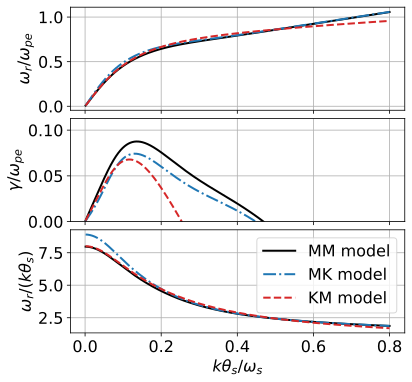

In [10]:
k_ticks = np.linspace(0,0.8,num=5)
fig = plt.figure(figsize=(6,6))

ax1 = plt.subplot(311)
ax1.plot(k_list*lds,w_MM_list,'-',color='black',label='MM model'    )
ax1.plot(k_list*lds,w_MK_list,'-.',color='tab:blue',label='MK model')
ax1.plot(k_list*lds,w_KM_list,'--',color='tab:red',label='KM model' )

ax1.set_ylabel(r'$\omega_r/\omega_{pe}$')
plt.xticks(k_ticks,[])
ax1.grid()

ax2 = plt.subplot(312)
plt.plot(k_list*lds,r_MM_list,'-',color='black',label='MM model')
plt.plot(k_list*lds,r_MK_list,'-.',color='tab:blue',label='MK model')
plt.plot(k_list*lds,r_KM_list,'--',color='tab:red',label='KM model')

plt.xticks(k_ticks,[])
ax2.set_ylabel(r'$\gamma/\omega_{pe}$')
ax2.set_ylim(0.,)
ax2.grid()

ax3 = plt.subplot(313)
ax3.plot(k_list*lds,w_MM_list/k_list/v_s,'-',color='black',label='MM model'    )
ax3.plot(k_list*lds,w_MK_list/k_list/v_s,'-.',color='tab:blue',label='MK model')
ax3.plot(k_list*lds,w_KM_list/k_list/v_s,'--',color='tab:red',label='KM model' )
ax3.set_xlabel(r'$k\theta_s/\omega_s$')
ax3.set_ylabel(r'$\omega_r/(k\theta_s)$')
ax3.legend(loc=1)
plt.xticks(k_ticks)
ax3.grid()

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./fig2_pdr.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

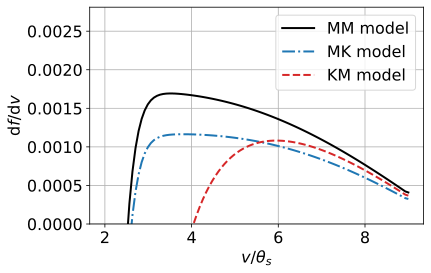

In [35]:
v_list_s = np.linspace(0.2,0.9,num=100)/v_s
fig = plt.figure(figsize=(6,4))

df2=np.gradient(f(v_list_s*v_s,kappa_s2,kappa_f2))
df1=np.gradient(f(v_list_s*v_s,kappa_s1,kappa_f1))
df3=np.gradient(f(v_list_s*v_s,kappa_s3,kappa_f3))

plt.plot(v_list_s,df3,'-',color='black',label='MM model')
plt.plot(v_list_s,df2,'-.',color='tab:blue',label='MK model')
plt.plot(v_list_s,df1,'--',color='tab:red',label='KM model')
# plt.yscale('log')
plt.xlabel(r'$v/\theta_s$')
plt.ylabel(r'$\mathrm{d}f/\mathrm{d}v$')
plt.legend(loc=1)
# plt.axvline(5.6)
plt.ylim(0.0,)
plt.grid()
# plt.savefig('./fig3_dev_pdf.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [36]:
# r_MM_list1 = r_MM_list
# r_KM_list1 = r_KM_list
# r_MK_list1 = r_MK_list
# r_MM_list2 = r_MM_list
# r_KM_list2 = r_KM_list
# r_MK_list2 = r_MK_list
# r_MM_list3 = r_MM_list
# r_KM_list3 = r_KM_list
# r_MK_list3 = r_MK_list

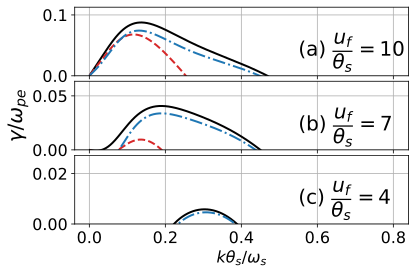

In [37]:
k_ticks = np.linspace(0,0.8,num=5)
fig = plt.figure(figsize=(6,4))

ax1 = plt.subplot(311)
ax1.plot(k_list*lds,r_MM_list1,'-',color='black',label='MM model'    )
ax1.plot(k_list*lds,r_KM_list1,'--',color='tab:red',label='KM model' )
ax1.plot(k_list*lds,r_MK_list1,'-.',color='tab:blue',label='MK model')
plt.xticks(k_ticks,[])
plt.text(0.55,0.033,r'(a) $\dfrac{u_f}{\theta_s}=10$',fontsize=20)
ax1.set_ylim(0.,)
ax1.grid()

ax2 = plt.subplot(312)
ax2.plot(k_list*lds,r_MM_list2,'-',color='black',label='MM model'    )
ax2.plot(k_list*lds,r_KM_list2,'--',color='tab:red',label='KM model' )
ax2.plot(k_list*lds,r_MK_list2,'-.',color='tab:blue',label='MK model')
plt.xticks(k_ticks,[])
plt.text(0.55,0.018,r'(b) $\dfrac{u_f}{\theta_s}=7$',fontsize=20)
ax2.set_ylabel(r'$\gamma/\omega_{pe}$', fontsize=20)
ax2.set_ylim(0.,)
ax2.grid()

ax3 = plt.subplot(313)
ax3.plot(k_list*lds,r_MM_list3,'-',color='black',label='MM model'    )
ax3.plot(k_list*lds,r_KM_list3,'--',color='tab:red',label='KM model' )
ax3.plot(k_list*lds,r_MK_list3,'-.',color='tab:blue',label='MK model')
plt.xticks(k_ticks)
plt.text(0.55,0.008,r'(c) $\dfrac{u_f}{\theta_s}=4$',fontsize=20)
ax3.set_xlabel(r'$k\theta_s/\omega_s$')
ax3.set_ylim(0.,)
ax3.grid()

plt.subplots_adjust(hspace = 0.08,wspace=0.0)
# plt.savefig('./fig4_r_a.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

## unstable regime

## $n_s$ vs $a$

In [11]:
n_s = 0.01
n_f = 1-n_s
v_s = 0.1
v_f = 1.0
a = 0
u_s = 0
q=1
wp_s = np.sqrt( n_s * q**2 )
wp_f = np.sqrt( n_f * q**2 )

# KM model
kappa_s1 = 2
kappa_f1 = 0
# MK model
kappa_s2 = 0
kappa_f2 = 2
# MM model
kappa_s3 = 0
kappa_f3 = 0

l_s1,l_f1,T_s1,T_f1 = SetParas(kappa_s1,kappa_f1)
l_s2,l_f2,T_s2,T_f2 = SetParas(kappa_s2,kappa_f2)
l_s3,l_f3,T_s3,T_f3 = SetParas(kappa_s3,kappa_f3)

rKM_max_mat = []
rMK_max_mat = []
rMM_max_mat = []

n_list = np.concatenate([np.linspace(n_s,0.85,num=38),np.linspace(0.85,0.99,num=4)])
a_list = np.linspace(0,8,num=50)
k_list = np.linspace(0.1,10.0,num=400)

w_KM_guess = 0.01
r_KM_guess = -0.01
w_MK_guess = 0.01
r_MK_guess = -0.01
w_MM_guess = 0.01
r_MM_guess = -0.01

w_KM_k0 = w_KM_a0 = w_KM_guess
r_KM_k0 = r_KM_a0 = r_KM_guess
w_MK_k0 = w_MK_a0 = w_MK_guess
r_MK_k0 = r_MK_a0 = r_MK_guess
w_MM_k0 = w_MM_a0 = w_MM_guess
r_MM_k0 = r_MM_a0 = r_MM_guess

In [12]:
for n_each in tqdm(n_list,position=0,leave=True):
    n_s = n_each
    n_f = 1 - n_s
    wp_s = np.sqrt( n_s * q**2 )
    wp_f = np.sqrt( n_f * q**2 )
    
    rKM_max_list = []
    rMK_max_list = []
    rMM_max_list = []
    for a_each in a_list:
        u_f = a_each*v_s
        l_s1,l_f1,T_s1,T_f1 = SetParas(kappa_s1,kappa_f1)
        l_s2,l_f2,T_s2,T_f2 = SetParas(kappa_s2,kappa_f2)
        l_s3,l_f3,T_s3,T_f3 = SetParas(kappa_s3,kappa_f3)
        rKM_list=np.array([])
        rMK_list=np.array([])
        rMM_list=np.array([])
        for k_each in k_list:
            sKM = op.root(lambda w:PDR(w,k_each,kappa_s1,kappa_f1),[w_KM_guess,r_KM_guess])
            if sKM.success==True:
                w_KM_guess = round(sKM.x[0],4)
                r_KM_guess = round(sKM.x[1],4)
                rKM_list = np.append(rKM_list,sKM.x[1])
            sMK = op.root(lambda w:PDR(w,k_each,kappa_s2,kappa_f2),[w_MK_guess,r_MK_guess])
            if sMK.success==True:
                w_MK_guess = round(sMK.x[0],6)
                r_MK_guess = round(sMK.x[1],6)
                rMK_list = np.append(rMK_list,sMK.x[1])
            if a_each>3.9:
                w_MM_guess = w_MK_guess
                r_MM_guess = r_MK_guess
            sMM = op.root(lambda w:PDR(w,k_each,kappa_s3,kappa_f3),[w_MM_guess,r_MM_guess])
            if sMM.success==True:
                w_MM_guess = round(sMM.x[0],6)
                r_MM_guess = round(sMM.x[1],6)
                rMM_list = np.append(rMM_list,sMM.x[1])
                
            if k_each == k_list[0]:
                w_KM_k0 = w_KM_guess
                r_KM_k0 = r_KM_guess
                w_MK_k0 = w_MK_guess
                r_MK_k0 = r_MK_guess
                w_MM_k0 = w_MM_guess
                r_MM_k0 = r_MM_guess
                if a_each == a_list[0]:
                    w_KM_a0 = w_KM_k0
                    r_KM_a0 = r_KM_k0
                    w_MK_a0 = w_MK_k0
                    r_MK_a0 = r_MK_k0
                    w_MM_a0 = w_MM_k0
                    r_MM_a0 = r_MM_k0
        rKM_max_list.append(np.amax(rKM_list))
        rMK_max_list.append(np.amax(rMK_list))
        rMM_max_list.append(np.amax(rMM_list))
        w_KM_guess = w_KM_k0
        r_KM_guess = r_KM_k0
        w_MK_guess = w_MK_k0
        r_MK_guess = r_MK_k0
        w_MM_guess = w_MM_k0
        r_MM_guess = r_MM_k0
    rKM_max_mat.append(rKM_max_list)
    rMK_max_mat.append(rMK_max_list)
    rMM_max_mat.append(rMM_max_list)
    
    w_KM_guess = w_KM_a0
    r_KM_guess = r_KM_a0
    w_MK_guess = w_MK_a0
    r_MK_guess = r_MK_a0
    w_MM_guess = w_MM_a0
    r_MM_guess = r_MM_a0

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [53:49<00:00, 76.89s/it]


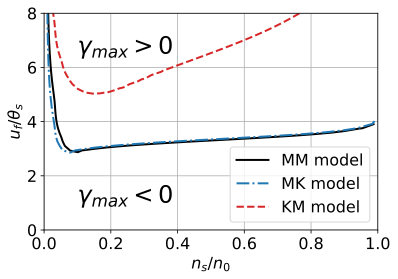

In [25]:
a_grid,n_s_grid=np.meshgrid(a_list,n_list)
plt.contour(n_s_grid,a_grid,rMM_max_mat,levels=[-1,0,1],linestyles='-',colors='black')
plt.contour(n_s_grid,a_grid,rMK_max_mat,levels=[-1,0,1],linestyles='-.',colors='tab:blue')
plt.contour(n_s_grid,a_grid,rKM_max_mat,levels=[-1,0,1],linestyles='--',colors='tab:red')
plt.plot([],[],'-',color='black',label='MM model')
plt.plot([],[],'-.',color='tab:blue',label='MK model')
plt.plot([],[],'--',color='tab:red',label='KM model')
plt.text(0.1,6.5,r'$\gamma_{max}>0$',fontsize=24)
plt.text(0.1,1,r'$\gamma_{max}<0$',fontsize=24)
# plt.axvline(0.5,linestyle=':')
# plt.axhline(3.33,linestyle=':')
plt.legend(loc=4)
plt.xlabel(r'$n_s/n_0$')
plt.ylabel(r'$u_f/\theta_s$')
plt.xlim(0,1)
plt.grid()
# plt.savefig('./fig5_para_a_n.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

## $v_f/v_s$ vs $a$

In [37]:
n_s = 0.5
n_f = 1-n_s
v_s = 0.1
v_f = 1.0
a = 0
u_s = 0
q=1
wp_s = np.sqrt( n_s * q**2 )
wp_f = np.sqrt( n_f * q**2 )

# KM model
kappa_s1 = 2
kappa_f1 = 0
# MK model
kappa_s2 = 0
kappa_f2 = 2
# MM model
kappa_s3 = 0
kappa_f3 = 0

l_s1,l_f1,T_s1,T_f1 = SetParas(kappa_s1,kappa_f1)
l_s2,l_f2,T_s2,T_f2 = SetParas(kappa_s2,kappa_f2)
l_s3,l_f3,T_s3,T_f3 = SetParas(kappa_s3,kappa_f3)

rKM_max_mat = []
rMK_max_mat = []
rMM_max_mat = []

vf_list = np.linspace(3.0,0.45,num=50)
a_list = np.linspace(0,10,num=50)
k_list = np.linspace(0.1,10.0,num=400)

w_KM_guess = 0.2
r_KM_guess = -0.1
w_MK_guess = 0.2
r_MK_guess = -0.1
w_MM_guess = 0.2
r_MM_guess = -0.1

w_KM_k0 = w_KM_a0 = w_KM_guess
r_KM_k0 = r_KM_a0 = r_KM_guess
w_MK_k0 = w_MK_a0 = w_MK_guess
r_MK_k0 = r_MK_a0 = r_MK_guess
w_MM_k0 = w_MM_a0 = w_MM_guess
r_MM_k0 = r_MM_a0 = r_MM_guess

In [38]:
for vf_each in tqdm(vf_list,position=0,leave=True):
    v_f = vf_each
    
    rKM_max_list = []
    rMK_max_list = []
    rMM_max_list = []
    for a_each in a_list:
        u_f = a_each*v_s
        l_s1,l_f1,T_s1,T_f1 = SetParas(kappa_s1,kappa_f1)
        l_s2,l_f2,T_s2,T_f2 = SetParas(kappa_s2,kappa_f2)
        l_s3,l_f3,T_s3,T_f3 = SetParas(kappa_s3,kappa_f3)
        rKM_list=np.array([])
        rMK_list=np.array([])
        rMM_list=np.array([])
        for k_each in k_list:
            sKM = op.root(lambda w:PDR(w,k_each,kappa_s1,kappa_f1),[w_KM_guess,r_KM_guess])
            if sKM.success==True:
                w_KM_guess = round(sKM.x[0],4)
                r_KM_guess = round(sKM.x[1],4)
                rKM_list = np.append(rKM_list,sKM.x[1])
            sMK = op.root(lambda w:PDR(w,k_each,kappa_s2,kappa_f2),[w_MK_guess,r_MK_guess])
            if sMK.success==True:
                w_MK_guess = round(sMK.x[0],6)
                r_MK_guess = round(sMK.x[1],6)
                rMK_list = np.append(rMK_list,sMK.x[1])
            if a_each>3.9:
                w_MM_guess = w_MK_guess
                r_MM_guess = r_MK_guess
            sMM = op.root(lambda w:PDR(w,k_each,kappa_s3,kappa_f3),[w_MM_guess,r_MM_guess])
            if sMM.success==True:
                w_MM_guess = round(sMM.x[0],6)
                r_MM_guess = round(sMM.x[1],6)
                rMM_list = np.append(rMM_list,sMM.x[1])
                
            if k_each == k_list[0]:
                w_KM_k0 = w_KM_guess
                r_KM_k0 = r_KM_guess
                w_MK_k0 = w_MK_guess
                r_MK_k0 = r_MK_guess
                w_MM_k0 = w_MM_guess
                r_MM_k0 = r_MM_guess
                if a_each == a_list[0]:
                    w_KM_a0 = w_KM_k0
                    r_KM_a0 = r_KM_k0
                    w_MK_a0 = w_MK_k0
                    r_MK_a0 = r_MK_k0
                    w_MM_a0 = w_MM_k0
                    r_MM_a0 = r_MM_k0
        rKM_max_list.append(np.amax(rKM_list))
        rMK_max_list.append(np.amax(rMK_list))
        rMM_max_list.append(np.amax(rMM_list))
        w_KM_guess = w_KM_k0
        r_KM_guess = r_KM_k0
        w_MK_guess = w_MK_k0
        r_MK_guess = r_MK_k0
        w_MM_guess = w_MM_k0
        r_MM_guess = r_MM_k0
    rKM_max_mat.append(rKM_max_list)
    rMK_max_mat.append(rMK_max_list)
    rMM_max_mat.append(rMM_max_list)
    
    w_KM_guess = w_KM_a0
    r_KM_guess = r_KM_a0
    w_MK_guess = w_MK_a0
    r_MK_guess = r_MK_a0
    w_MM_guess = w_MM_a0
    r_MM_guess = r_MM_a0

100%|████████████████████████████████████████████████████████████████████████████████| 50/50 [1:05:43<00:00, 78.86s/it]


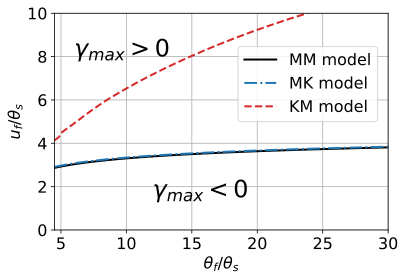

In [41]:
a_grid,vf_grid=np.meshgrid(a_list,vf_list/v_s)
plt.contour(vf_grid,a_grid,rMM_max_mat,levels=[-1,0],linestyles='-',colors='black')
plt.contour(vf_grid,a_grid,rMK_max_mat,levels=[-1,0],linestyles='-.',colors='tab:blue')
plt.contour(vf_grid,a_grid,rKM_max_mat,levels=[-1,0],linestyles='--',colors='tab:red')
plt.plot([],[],'-',color='black',label='MM model')
plt.plot([],[],'-.',color='tab:blue',label='MK model')
plt.plot([],[],'--',color='tab:red',label='KM model')
plt.text(6,8,r'$\gamma_{max}>0$',fontsize=24)
plt.text(12,1.5,r'$\gamma_{max}<0$',fontsize=24)
# plt.xscale('log')
plt.legend(loc=[0.55,0.5])
plt.xlabel(r'$\theta_f/\theta_s$')
plt.ylabel(r'$u_f/\theta_s$')
plt.grid()
# plt.savefig('./fig6_para_a_vfvs.pdf',dpi=600,bbox_inches = 'tight')
plt.show()